# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [201]:
# Imports here
import numpy as np
import json
import torch
import matplotlib.pyplot as plt

from torch import nn, optim
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [202]:
# check for GPU
use_gpu = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_gpu else {}
print("GPU {}".format("Available" if use_gpu else "Not Available"))

GPU Not Available


In [203]:
data_dir = "flowers"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"
test_dir = data_dir + "/test"

In [204]:
# pre-trained network expectations
network_means = [0.485, 0.456, 0.406]
network_std = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
BATCH_SIZE = 64

In [205]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    "training": transforms.Compose([transforms.RandomVerticalFlip(),
                                    transforms.RandomRotation(30),
                                    transforms.RandomResizedCrop(IMAGE_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize(network_means, network_std)]),

    "validation": transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(IMAGE_SIZE),
                                      transforms.ToTensor(),
                                      transforms.Normalize(network_means, network_std)]),

    "testing": transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(IMAGE_SIZE),
                                   transforms.ToTensor(),
                                   transforms.Normalize(network_means, network_std)])

}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    "training": datasets.ImageFolder(train_dir, transform=data_transforms["training"]),
    "validation": datasets.ImageFolder(valid_dir, transform=data_transforms["validation"]),
    "testing": datasets.ImageFolder(test_dir, transform=data_transforms["testing"])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    "training": torch.utils.data.DataLoader(image_datasets["training"], batch_size=BATCH_SIZE, shuffle=True, **kwargs),
    "validation": torch.utils.data.DataLoader(image_datasets["validation"], batch_size=BATCH_SIZE, shuffle=True, **kwargs),
    "testing": torch.utils.data.DataLoader(image_datasets["testing"], batch_size=BATCH_SIZE, shuffle=False, **kwargs)
}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [206]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print("There are in total {} different categories.".format(len(cat_to_name)))


There are in total 102 different categories.


# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [207]:
# TODO: Build and train your network

def load_vgg_model(hidden_units):
    model = models.vgg16(weights='IMAGENET1K_V1')

   # prevent backpropagation on network parameters by freezing parameters
    for param in model.parameters():
        param.requires_grad = False

    # input size from current classifier
    input_size = model.classifier[0].in_features
    # setting OUTPUT_SIZE dynamically to the number of categories (which in this case is 102 in the json file)
    output_size = len(cat_to_name)
    
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_units)),
        ('relu', nn.ReLU()),
        ('dropout', nn.Dropout(p=0.1)),
        ('fc2', nn.Linear(hidden_units, output_size)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.classifier = classifier

    return model

In [208]:
def create_new_model(learning_rate, hidden_units, class_to_idx):

    # load the pretrained vgg model
    model = load_vgg_model(hidden_units)
    # set training parameters
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    # using the Adam optimizer
    optimizer = optim.Adam(parameters, lr=learning_rate)
    # loss criterion is "negative log likelihood loss" which is useful to train classification problems
    criterion = nn.NLLLoss()
    # save class to index mapping
    model.class_to_idx = class_to_idx

    return model, optimizer, criterion


In [209]:
# load pretrained model
learning_rate = 0.001
hidden_units = 400

# get class to index mapping
class_to_idx = image_datasets['training'].class_to_idx

model, optimizer, criterion = create_new_model(learning_rate, hidden_units, class_to_idx)

In [210]:
# move tensors to GPU if available
if use_gpu:
    model.cuda()
    criterion.cuda()

In [211]:
def validate_model(model, criterion, data_loader):
    # model in inference mode
    model.eval()
    # initiate the accuracy and loss at zero
    accuracy = 0
    loss = 0

    for images, labels in iter(data_loader):

        with torch.no_grad():
            if use_gpu:
                images = images.float().cuda()
                labels = labels.long().cuda()
            else:
                images = images
                labels = labels
            
            
        output = model.forward(images)
        loss += criterion(output, labels).item()

        # since the model's output is log-softmax, taking exponentials to get the probabilities of classes
        prob = torch.exp(output).data

        # class with highest probability is the predicted class
        prediction = (labels.data == prob.max(1)[1])

        # accuracy is the number of correct predictions divided by all predictions
        accuracy += prediction.type_as(torch.FloatTensor()).mean()

    valid_loss = loss/len(data_loader)
    valid_acc = accuracy/len(data_loader)

    return valid_loss, valid_acc


In [212]:
def train_model(model, criterion, optimizer, epochs, training_data_loader, validation_data_loader):
    # model in training mode
    model.train()

    # set the batch sizes inside epochs
    print_every = 40
    steps = 0

    for epoch in range(epochs):
        running_loss = 0

        for images, labels in iter(training_data_loader):
            steps += 1

            # move tensors to GPU if available
            with torch.no_grad():
                if use_gpu:
                    images = images.float().cuda()
                    labels = labels.long().cuda()
                else:
                    images = images
                    labels = labels

            # set gradients to zero
            optimizer.zero_grad()
            # do a forward pass
            output = model.forward(images)
            # calculate loss
            loss = criterion(output, labels)
            # do a backward pass
            loss.backward()
            # update weights using the Adam optimizer
            optimizer.step()
            # update the running total of loss
            running_loss += loss.item()

            if steps % print_every == 0:
                validation_loss, validation_accuracy = validate_model(model, criterion, validation_data_loader)

                print("EPOCH: {}/{}\t".format(epoch+1, epochs),
                      "Training Loss: {:.3f}\t".format(running_loss/print_every),
                      "Validation Loss: {:.3f}\t".format(validation_loss),
                      "Validation Accuracy: {:.3f}".format(validation_accuracy))

                # set the running total back to zero for the next epoch
                running_loss = 0

                # set the model back into training mode
                model.train()


In [213]:
# Train the network using traning data
EPOCHS = 3

train_model(model, criterion, optimizer, EPOCHS, dataloaders['training'], dataloaders['validation'])

EPOCH: 1/3	 Training Loss: 3.478	 Validation Loss: 1.909	 Validation Accuracy: 0.555
EPOCH: 1/3	 Training Loss: 1.962	 Validation Loss: 1.120	 Validation Accuracy: 0.701
EPOCH: 2/3	 Training Loss: 0.548	 Validation Loss: 0.764	 Validation Accuracy: 0.787
EPOCH: 2/3	 Training Loss: 1.186	 Validation Loss: 0.732	 Validation Accuracy: 0.799
EPOCH: 2/3	 Training Loss: 1.181	 Validation Loss: 0.623	 Validation Accuracy: 0.838
EPOCH: 3/3	 Training Loss: 0.864	 Validation Loss: 0.663	 Validation Accuracy: 0.820
EPOCH: 3/3	 Training Loss: 0.982	 Validation Loss: 0.517	 Validation Accuracy: 0.869


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [214]:
# TODO: Do validation on the test set

validation_loss, validation_accuracy = validate_model(model, criterion, dataloaders['testing'])
print("Validation Accuracy: {:.3f}".format(validation_accuracy))

Validation Accuracy: 0.852


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [215]:
# TODO: Save the checkpoint 

checkpoint_path = 'vgg16_checkpoint.pth'

state = {
    'arch': 'vgg16',
    'learning_rate': learning_rate,
    'hidden_units': hidden_units,
    'epochs': EPOCHS,
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'class_to_idx': model.class_to_idx
}

torch.save(state, checkpoint_path)


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [216]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

checkpoint_path = 'vgg16_checkpoint.pth'

state = torch.load(checkpoint_path)

learning_rate = state['learning_rate']
class_to_idx = state['class_to_idx']

# create pretrained model
model, optimizer, criterion = create_new_model(learning_rate, hidden_units, class_to_idx)

# load checkpoint state into the model
model.load_state_dict(state['state_dict'])
optimizer.load_state_dict(state['optimizer'])

print("Loaded '{}' (arch={}, hidden_units={}, epochs={})".format(
    checkpoint_path,
    state['arch'],
    state['hidden_units'],
    state['epochs']))


# move tensors to GPU if available
if use_gpu:
    model.cuda()
    criterion.cuda()

Loaded 'vgg16_checkpoint.pth' (arch=vgg16, hidden_units=400, epochs=3)


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [217]:
def resize_image(image, size):
    ''' Resize the image where the shortest side is as many pixels as what is provided with the "size" variable,
        keeping the aspect ratio  
    '''
    w, h = image.size

    if h > w:
        # set width to "size" and scale height to keep the aspect ratio
        h = int(max(h * size / w, 1))
        w = int(size)
    else:
        # set height to "size" and scale width to keep the aspect ratio
        w = int(max(w * size / h, 1))
        h = int(size)

    return image.resize((w, h))


In [218]:
def crop_image(image, size):
    ''' Crop out the center portion of the image as big as what is provided with the "size" variable
    '''
    w, h = image.size

    x1 = (w - size) / 2   # where x1 is the leftmost x-coordinate of the center portion
    y1 = (h - size) / 2   # where y1 is the downmost y-coordinate of the center portion

    x2 = x1 + size      # where x2 is the rightmost x-coordinate of the center portion
    y2 = y1 + size      # where y2 is the uppermost y-coordinate of the center portion

    return image.crop((x1, y1, x2, y2))


In [219]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model

    # resize image where the shortest side is 256 pixels       
    resized_image = resize_image(image, 256)
    
    # crop out the center 224x224 portion of the image
    cropped_image = crop_image(resized_image, 224)
    
    # convert the color channels of images (encoded as integers 0-255) to floats (interval 0-1)
    np_image = np.array(cropped_image) / 255.

    # normalize images
    mean = np.array(network_means)
    std = np.array(network_std)     
    np_image = (np_image - mean) / std
        
    # PyTorch expects the color channel to be the first dimension
    # but it's the third dimension in the PIL image and Numpy array
    np_image = np_image.transpose((2, 0, 1))
    
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [220]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [221]:
# check that the "process_image" function works by showing the original image

# BEFORE
image_example = train_dir + "/7/image_07207.jpg"
image = Image.open(image_example)
image.show()

<AxesSubplot:>

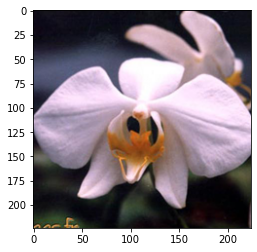

In [222]:
# AFTER
np_array = process_image(image)
tensor = torch.from_numpy(np_array)
imshow(tensor)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [229]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file

    # set model in inference mode
    model.eval()

    image = Image.open(image_path)
    np_array = process_image(image)
    tensor = torch.from_numpy(np_array)

    # use GPU if available
    if use_gpu:
        tensor_V = tensor.float().cuda()
    else:
        tensor_V = tensor.float()

    # add a new dimension as the model is expecting a 4d tensor
    tensor_V = tensor_V.unsqueeze(0)

    # "with torch.no_grad():" apparently serves the same purpose as "Variable(tensor, volatile=True)"
    # disabling gradient calculation 
    with torch.no_grad():
        # do a forward run through the model
        output = model.forward(tensor_V)

        # since the model's output is log-softmax, taking exponentials to get the probabilities of classes
        #probs, classes = torch.exp(output).data.topk(topk)
        probs, classes = torch.topk(output, topk)
        probs = probs.exp()

        # Move results to CPU if needed
        probs = probs.cpu() if use_gpu else probs
        classes = classes.cpu() if use_gpu else classes

    # map classes to indices
    inverted_class_to_idx = {model.class_to_idx[k]: k for k in model.class_to_idx}

    mapped_classes = list()

    for label in classes.numpy()[0]:
        mapped_classes.append(inverted_class_to_idx[label])

    return probs.numpy()[0], mapped_classes


In [230]:
# check that the "predict" function works

image_example = test_dir + "/11/image_03130.jpg"
probs, classes = predict(image_example, model)

print(probs)
print(classes)

[0.8856767  0.09200254 0.01503849 0.00471179 0.00140971]
['11', '94', '4', '74', '85']


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [231]:
def get_title(label):
    try:
        return cat_to_name[label]
    except KeyError:
        return "unknown label"


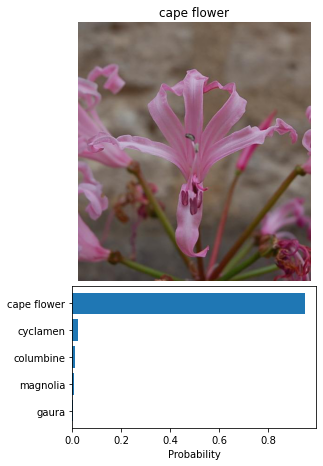

In [240]:
# TODO: Display an image along with the top 5 classes

image_example = test_dir + "/37/image_03789.jpg"

# get top k predictions (default: 5)
probs, classes = predict(image_example, model)

max_index = np.argmax(probs)
max_prob = probs[max_index]
max_label = classes[max_index]

# create a figure
fig = plt.figure(figsize=(8, 8))
ax1 = plt.subplot2grid((15, 9), (0, 0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15, 9), (9, 2), colspan=5, rowspan=5)

# display image
image = Image.open(image_example)
ax1.axis("off")
ax1.set_title(get_title(max_label))
ax1.imshow(image)

# display the top 5 classes as a bar graph
labels = (get_title(i) for i in classes)
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.invert_yaxis() 
ax2.set_xlabel("Probability")
ax2.barh(y_pos, probs)
plt.show()


References: 
1. https://github.com/craig-martinson/aipnd-project
2. https://github.com/fepegar/torchio/issues/295
3. https://stackoverflow.com/questions/59013109/runtimeerror-input-type-torch-floattensor-and-weight-type-torch-cuda-floatte
4. https://pytorch.org/vision/master/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights